# PySpark Data Engineering: Energy Analysis

## Introduction

This notebook demonstrates the use of PySpark for data engineering tasks, transitioning from traditional databases like PostgreSQL and MongoDB to distributed data processing with PySpark. The goal is to showcase proficiency in data loading, exploration, transformation, and analysis using PySpark, as well as to highlight the scalability and efficiency of distributed computing for large datasets.

We will use datasets from [Open Power System Data (OPSD)](https://open-power-system-data.org/) to perform exploratory data analysis (EDA), data transformations, and machine learning tasks.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

## 1. Data Download

We will download the time_series_60min_singleindex.csv dataset from OPSD, which contains hourly time series data for power systems in Europe.

In [2]:
# URL and save path
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
save_path = "data/raw/time_series_60min_singleindex.csv"


In [3]:
import os
import requests
from pathlib import Path

def download_data(url, save_path):
    try:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Convert the save path to a canonical path
        save_path = Path(save_path).resolve()

        # Check if the file already exists
        if os.path.exists(save_path):
            print(f"File already exists at {save_path}. Skipping download.")
            return
        
        # Download the file
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful

        # Save the file
        with open(save_path, 'wb') as file:
            file.write(response.content)
        
        print(f"Data downloaded successfully and saved to {save_path}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading data: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Download the data
download_data(url, save_path)

File already exists at C:\slPrivateData\00_portfolio\pyspark_energy_analysi\data\raw\time_series_60min_singleindex.csv. Skipping download.


### Dataset Description

The dataset contains hourly time series data for:

- Renewable energy generation (solar, wind, etc.)

- Conventional power generation

- Electricity consumption

- Cross-border electricity exchanges

This data is crucial for analyzing energy trends and optimizing power systems.

## 3. Data Loading

We will load the downloaded CSV file into a PySpark DataFrame.

### initialize Spark Session

In [4]:
from pyspark.sql import SparkSession

def initialize_spark_session(app_name: str, master: str = "local[*]", **kwargs) -> SparkSession:
    """
    Initialize a Spark session with the given configuration.

    Args:
        app_name (str): The name of the Spark application.
        master (str, optional): The Spark master URL. Defaults to "local[*]".
        **kwargs: Additional configuration options.

    Returns:
        SparkSession: The initialized Spark session.
    """
    # Stop any existing Spark session
    if 'spark' in globals():
        spark.stop()

    # Initialize Spark session
    return SparkSession.builder.appName(app_name) \
        .master(master) \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "1") \
        .config("spark.ui.port", "4041") \
        .config("spark.executor.heartbeatInterval", "60s") \
        .config("spark.network.timeout", "800s") \
        .config("spark.driver.maxResultSize", "4g") \
        .config("spark.sql.shuffle.partitions", "200") \
        .config("spark.default.parallelism", "100") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.adaptive.enabled", "true") \
        .getOrCreate()


In [5]:
spark = initialize_spark_session("EnergyAnalysis")

In [6]:
# Print SparkSession information
print("SparkSession:")
print("----------------")
print(f"SparkContext: {spark.sparkContext}")
print("Spark UI: {}".format(spark.sparkContext.uiWebUrl))
print(f"Version: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"AppName: {spark.sparkContext.appName}")

SparkSession:
----------------
SparkContext: <SparkContext master=local[*] appName=EnergyAnalysis>
Spark UI: http://ERENL004:4041
Version: 3.5.5
Master: local[*]
AppName: EnergyAnalysis


In [7]:
spark

In [8]:
# Get all configuration properties of the Spark context
conf = spark.sparkContext.getConf().getAll()

# Print configuration properties
for key, value in conf:
    print(f"{key}: {value}")

spark.app.id: local-1742907478858
spark.app.name: EnergyAnalysis
spark.executor.cores: 4
spark.ui.port: 4041
spark.driver.memory: 8g
spark.serializer.objectStreamReset: 100
spark.app.submitTime: 1742907477825
spark.sql.shuffle.partitions: 200
spark.sql.warehouse.dir: file:/C:/slPrivateData/00_portfolio/pyspark_energy_analysi/spark-warehouse
spark.master: local[*]
spark.submit.deployMode: client
spark.sql.execution.arrow.pyspark.enabled: true
spark.app.startTime: 1742907477958
spark.driver.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.a

### Load Data

In [9]:
def load_csv(spark, file_path, options):
    """
    Load a CSV file using PySpark with specified options
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    options : dict
        Options for loading the CSV file
    
    Returns:
    --------
    spark.DataFrame
    """
    return spark.read.options(**options).csv(file_path)

from pyspark.sql.types import NumericType, StringType

def get_numerical_columns(df):
    """
    Get the list of numerical columns in the DataFrame.

    Parameters
    ----------
    df : pyspark.sql.dataframe.DataFrame
        The DataFrame to get numerical columns from.

    Returns
    -------
    list
        A list of numerical column names.
    """
    return [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

def get_categorical_columns(df):
    """
    Get the list of categorical columns in the DataFrame.

    Parameters
    ----------
    df : pyspark.sql.dataframe.DataFrame
        The DataFrame to get categorical columns from.

    Returns
    -------
    list
        A list of categorical column names.
    """
    return [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

def get_timestamp_columns(df):
    return [col for col in df.columns 
                     if any(time_keyword in col.lower() 
                           for time_keyword in ["time", "date", "timestamp", "hour", "day"])]

def create_sample(df, sampling_ratio, seed):
    """
    Create a smaller sample of a DataFrame
    
    Parameters:
    -----------
    df : spark.DataFrame
        DataFrame to sample
    sampling_ratio : float
        Ratio for sampling data (between 0 and 1)
    seed : int
        Seed for reproducibility
    
    Returns:
    --------
    spark.DataFrame
    """
    return df.sample(withReplacement=False, fraction=sampling_ratio, seed=seed)

def cache_data(df):
    """
    Cache a DataFrame for faster subsequent operations
    
    Parameters:
    -----------
    df : spark.DataFrame
        DataFrame to cache
    
    Returns:
    --------
    spark.DataFrame
    """
    df.cache()
    return df

def create_metadata(df):
    """
    Print information about a DataFrame
    
    Parameters:
    -----------
    df : spark.DataFrame
        DataFrame to print information about
    """
    
    return {"rows": df.count(),
            "columns": len(df.columns),
            "timestamp_col": get_timestamp_columns(df),
            "numeric_cols": get_numerical_columns(df),
            "categorical_cols": get_categorical_columns(df)}
    print(f"Dataset size: {df.count():,} Records - {len(df.columns):,} Features")

def load_data(spark, file_path, cache=True):
    """
    Load a large CSV file efficiently using PySpark
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    sampling_ratio : float
        Ratio for sampling data (between 0 and 1)
    cache : bool
        Whether to cache the DataFrame for faster subsequent operations
    
    Returns:
    --------
    tuple: (full_df, sampled_df)
        full_df: Full PySpark DataFrame
        sampled_df: Sampled PySpark DataFrame for quick exploration
    """
    options = {
        "header": "true",
        "inferSchema": "true",
        "mode": "DROPMALFORMED"
    }
    
    df = load_csv(spark, file_path, options)
    
    if cache:
        df = cache_data(df)
    
    return df, create_metadata(df)

In [10]:
full_df, metadata = load_data(spark, save_path)

### Explore schema

In [11]:
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.types import StructField
import pandas as pd
import os
from typing import List, Dict, Optional


def validate_df(df: SparkDataFrame) -> None:
    """
    Validate if the input is a PySpark DataFrame
    
    Args:
        df: The input to validate
    
    Raises:
        TypeError: if the df is not a spark dataframe
    """
    if not isinstance(df, SparkDataFrame):
        raise TypeError("Input 'df' must be a PySpark DataFrame.")

def validate_output_dir(output_dir: Optional[str]) -> str:
    """
    Validate if the output directory is a valid path
    
    Args:
        output_dir: The directory to validate
    
    Returns:
        str: The validated output directory
    
    Raises:
        ValueError: if the output_dir is not a valid path
    """
    if output_dir is None:
        output_dir = os.getcwd()
    if not os.path.isdir(output_dir):
        raise ValueError(f"output_dir: {output_dir} is not a directory")
    return output_dir

def extract_schema_info(df: SparkDataFrame) -> List[Dict[str, str]]:
    """
    Extract schema information from a PySpark DataFrame
    
    Args:
        df: The PySpark DataFrame to extract schema from
    
    Returns:
        List[Dict[str, str]]: A list of dictionaries containing column name and data type
    """
    schema_info = []
    for field in df.schema.fields:
        if isinstance(field, StructField):
            schema_info.append({"Column Name": field.name, "Data Type": str(field.dataType)})
        else:
            raise TypeError("Each field in the df.schema.fields must be a StructField")
    return schema_info

def print_schema_info(schema_info: List[Dict[str, str]]) -> None:
    """
    Print schema information
    
    Args:
        schema_info: A list of dictionaries containing column name and data type
    """
    print("\nDataFrame Structure:")
    print(pd.DataFrame(schema_info))

def save_schema_info(schema_info: List[Dict[str, str]], output_dir: str) -> None:
    """
    Save schema information to a CSV file
    
    Args:
        schema_info: A list of dictionaries containing column name and data type
        output_dir: The directory to save the schema information CSV
    """
    output_path = os.path.join(output_dir, "schema_info.csv")
    pd.DataFrame(schema_info).to_csv(output_path, index=False)
    print(f"Schema information saved to: {output_path}")

def explore_schema(df: SparkDataFrame, output_dir: Optional[str] = None) -> None:
    """
    Explores and documents the schema of a PySpark DataFrame.
    
    Prints the schema to the console and saves a structured representation
    (column name and data type) to a CSV file.
    
    Args:
        df: The PySpark DataFrame to explore.
        output_dir: The directory to save the schema information CSV.
                    Defaults to the current working directory if not provided.
    """
    validate_df(df)
    output_dir = validate_output_dir(output_dir)
    
    print("DataFrame Schema:")
    df.printSchema()
    
    schema_info = extract_schema_info(df)
    print_schema_info(schema_info)
    save_schema_info(schema_info, output_dir)
    return schema_info

In [12]:
schema_info = explore_schema(full_df)

DataFrame Schema:
root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = tru

In [13]:
# Show the first few rows of the DataFrame
full_df.show(5)

+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [14]:
# Return a dataframe with only the columns that contain keywords from a list
def filter_columns(df, keywords):
    return df.select([col for col in df.columns if any(keyword.lower() in col.lower() for keyword in keywords)])

In [15]:
full_df_de = filter_columns(full_df, ["utc","DE"])
full_df_de.show(5)

+-------------------+----------------------------------+------------------------------------+-----------------+--------------------------+----------------+----------------+-------------------------+---------------+-------------------------+----------------------------------+------------------------+------------------------+---------------------------------+-----------------------+------------------------------------------+--------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+-----------------------------------------+-------------------------------------+---------------------------------------+---------------------+-----------------------------+----------------------------+-------------------------------------+------------------------------------+------------------------------------------+--------------------------------------------+----------------------------------+------------------

### Select Sample Size for EDA

#### Advanced Sample Selection

##### 1. Define Sampling Parameters

In [16]:
import math

def calculate_sample_size(
    confidence_level: float,
    margin_of_error: float,
    population_size: int = None,
    std_dev: float = 0.5
) -> int:
    """
    Calculate the required sample size for a given confidence level and margin of error,
    with optional finite population correction (FPC).

    Parameters:
    -----------
    confidence_level : float
        Confidence level (e.g., 0.90 for 90%)
    margin_of_error : float
        Margin of error (e.g., 0.10 for ±10%)
    population_size : int, optional
        Total population size. If provided, applies finite population correction.
    std_dev : float, optional
        Standard deviation (default 0.5 for maximum variability).

    Returns:
    --------
    int
        Required sample size
    """
    # Z-scores for common confidence levels
    z_scores = {
        0.80: 1.28,
        0.85: 1.44,
        0.90: 1.645,
        0.95: 1.96,
        0.99: 2.58
    }
    
    # Handle missing confidence level
    if confidence_level not in z_scores:
        closest_key = min(z_scores.keys(), key=lambda x: abs(x - confidence_level))
        print(f"Warning: Confidence level {confidence_level} not found. Using closest: {closest_key}")
        z = z_scores[closest_key]
    else:
        z = z_scores[confidence_level]
    
    # Calculate initial sample size (Cochran's formula)
    n = ((z ** 2) * std_dev * (1 - std_dev)) / (margin_of_error ** 2)
    
    # Apply finite population correction if population_size is provided
    if population_size is not None and n > 0:
        n = n / (1 + (n - 1) / population_size)
    
    return math.ceil(n)

##### 2. Sampling Strategies Implementation

In [17]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

# 3.1 Random Sampling
def random_sampling(data, sample_size):
    """Perform random sampling on the dataset"""
    return data.sample(fraction=sample_size/data.count(), seed=42)

# 3.2 Systematic Sampling - take every nth record
def systematic_sampling(data: DataFrame, sample_size: int, timestamp_column: str = "utc_timestamp") -> DataFrame:
    """Perform systematic sampling on the dataset"""
    
    # Calculate the total number of records and step size
    total_records = data.count()
    n = total_records // sample_size
    print(f"Total records: {total_records}, Sample size: {sample_size}, Step size: {n}")
    
    # Order the data by the timestamp column
    ordered_data = data.orderBy(timestamp_column)
    
    # Add an index column to the DataFrame
    indexed_data = ordered_data.withColumn("index", F.monotonically_increasing_id())
    
    # Filter the rows based on the index
    sampled_data = indexed_data.filter((F.col("index") % n) == 0).drop("index")
    
    return sampled_data

# 3.3 Stratified Sampling based on time periods

def stratified_time_sampling(data, sample_size, timestamp_column: str = "utc_timestamp"):
    """Perform stratified sampling based on time periods"""

    # Add time period columns (hour, day, month)
    data_with_periods = data.withColumn("hour", F.hour(timestamp_column)) \
                            .withColumn("day", F.dayofweek(timestamp_column)) \
                            .withColumn("month", F.month(timestamp_column))

    # Create a composite stratum key
    data_with_periods = data_with_periods.withColumn("stratum_key", 
                                                     F.concat_ws("_", 
                                                                 F.col("month"), 
                                                                 F.col("day"), 
                                                                 F.col("hour")))

    # Get counts for each stratum
    strata_counts = data_with_periods.groupBy("stratum_key").count().collect()
    total_count = data.count()

    # Calculate sampling fractions for each stratum
    strata_fractions = {row["stratum_key"]: min(sample_size / total_count, 1.0) for row in strata_counts}

    # Perform stratified sampling
    sampled_data = data_with_periods.sampleBy("stratum_key", strata_fractions, seed=42)

    # If we got more than needed, take a subsample
    if sampled_data.count() > sample_size:
        sampled_data = sampled_data.sample(fraction=sample_size / sampled_data.count(), seed=42)

    # Drop the added columns
    sampled_data = sampled_data.drop("hour", "day", "month", "stratum_key")

    return sampled_data

# 3.4 Time-based Clustering Sampling
def cluster_sampling(data, sample_size, num_clusters=10, timestamp_column="utc_timestamp"):
    """
    Perform time-based cluster sampling
    
    First divide the time range into clusters (time windows),
    then sample from each cluster
    """
    # Get min and max timestamps
    min_max_times = data.agg(
        F.min(timestamp_column).alias("min_time"),
        F.max(timestamp_column).alias("max_time")
    ).collect()[0]
    
    min_time = min_max_times["min_time"]
    max_time = min_max_times["max_time"]
    
    # Calculate time range and cluster interval
    from datetime import timedelta
    total_seconds = (max_time - min_time).total_seconds()
    interval_seconds = total_seconds / num_clusters
    
    # Generate cluster boundaries
    cluster_boundaries = [min_time + timedelta(seconds=i*interval_seconds) for i in range(num_clusters+1)]
    
    # Initialize empty DataFrame for results
    sampled_data = None
    samples_per_cluster = sample_size // num_clusters
    
    # Sample from each cluster
    for i in range(num_clusters):
        cluster_data = data.filter(
            (F.col(timestamp_column) >= cluster_boundaries[i]) & 
            (F.col(timestamp_column) < cluster_boundaries[i+1])
        )
        
        # Skip empty clusters
        if cluster_data.count() == 0:
            continue
        
        # Sample from this cluster
        cluster_sample = cluster_data.sample(
            fraction=min(1.0, samples_per_cluster/cluster_data.count()), 
            seed=42+i
        )
        
        # Add to the result
        if sampled_data is None:
            sampled_data = cluster_sample
        else:
            sampled_data = sampled_data.union(cluster_sample)
    
    return sampled_data

# 3.5 Reservoir Sampling for streams or very large datasets
def reservoir_sampling_simulation(data, sample_size):
    """
    Simulate reservoir sampling which is useful for streaming data
    
    This is a simulation because in a notebook we already have all the data.
    In a real streaming scenario, this would be implemented differently.
    """
    # For simulation purposes, we'll use Spark's sample function
    return data.sample(fraction=sample_size/data.count(), seed=42)

# 3.6 Adaptive Sampling based on data variance
def adaptive_sampling(data, base_sample_size, max_sample_size):
    """
    Implement adaptive sampling based on data variance
    
    We first take a small sample and compute the coefficient of variation.
    Then we adjust the sample size based on the variance.
    """
    # Take an initial sample
    initial_sample = data.sample(fraction=base_sample_size/data.count(), seed=42)
    
    # Calculate coefficient of variation for some key columns
    # For simplicity, we'll check variance in temperature and energy sensors
    temp_cols = [col for col in data.columns if "temperature" in col][:5]  # Just use a few columns
    energy_cols = [col for col in data.columns if "energy" in col][:5]
    
    # Function to calculate coefficient of variation (CV)
    def calculate_cv(df, col):
        stats_df = df.select(
            F.mean(col).alias("mean"),
            F.stddev(col).alias("stddev")
        ).collect()[0]
        
        mean = stats_df["mean"]
        stddev = stats_df["stddev"]
        
        # Avoid division by zero
        if mean == 0:
            return float('inf')
        
        return stddev / abs(mean)
    
    # Calculate average CV for the selected columns
    cv_values = []
    for col in temp_cols + energy_cols:
        cv = calculate_cv(initial_sample, col)
        if not math.isinf(cv):
            cv_values.append(cv)
    
    avg_cv = sum(cv_values) / len(cv_values) if cv_values else 1.0
    
    # Adjust sample size based on CV
    # Higher CV means more variance, which requires larger sample
    adjustment_factor = min(max(avg_cv, 0.5), 5.0)  # Limit between 0.5 and 5
    adjusted_sample_size = min(int(base_sample_size * adjustment_factor), max_sample_size)
    
    print(f"Average Coefficient of Variation: {avg_cv:.4f}")
    print(f"Adjustment Factor: {adjustment_factor:.4f}")
    print(f"Adjusted Sample Size: {adjusted_sample_size} (from base of {base_sample_size})")
    
    # Take the adjusted sample
    return data.sample(fraction=adjusted_sample_size/data.count(), seed=42)

##### 3. Evaluate and Compare Sampling Methods

In [18]:
# Set desired parameters
CONFIDENCE_LEVEL = 0.95  # 95% confidence level
MARGIN_OF_ERROR = 0.01   # 3% margin of error

# Calculate required sample size based on confidence level and margin of error
sample_size = calculate_sample_size(CONFIDENCE_LEVEL, MARGIN_OF_ERROR)
print(f"Required sample size for {CONFIDENCE_LEVEL*100}% confidence level and {MARGIN_OF_ERROR*100}% margin of error: {sample_size}")

Required sample size for 95.0% confidence level and 1.0% margin of error: 9604


In [19]:
# Apply different sampling methods
print("\nApplying sampling methods...")
random_sample = random_sampling(full_df_de, sample_size)
systematic_sample = systematic_sampling(full_df_de, sample_size)
stratified_sample = stratified_time_sampling(full_df_de, sample_size)
cluster_sample = cluster_sampling(full_df_de, sample_size)
reservoir_sample = reservoir_sampling_simulation(full_df_de, sample_size)
adaptive_sample = adaptive_sampling(full_df_de, sample_size, sample_size*10)

# Cache the samples for repeated use
random_sample.cache()
systematic_sample.cache()
stratified_sample.cache()
cluster_sample.cache()
reservoir_sample.cache()
adaptive_sample.cache()

# Get actual sample sizes
print(f"Random Sample Size: {random_sample.count()}")
print(f"Systematic Sample Size: {systematic_sample.count()}")
print(f"Stratified Sample Size: {stratified_sample.count()}")
print(f"Cluster Sample Size: {cluster_sample.count()}")
print(f"Reservoir Sample Size: {reservoir_sample.count()}")
print(f"Adaptive Sample Size: {adaptive_sample.count()}")


Applying sampling methods...
Total records: 50401, Sample size: 9604, Step size: 5
Average Coefficient of Variation: 1.0000
Adjustment Factor: 1.0000
Adjusted Sample Size: 9604 (from base of 9604)
Random Sample Size: 9643
Systematic Sample Size: 10080
Stratified Sample Size: 9600
Cluster Sample Size: 9590
Reservoir Sample Size: 9643
Adaptive Sample Size: 9643


##### 4. Plot Sampled Dataframes

In [20]:
# List of sample DataFrames and their corresponding titles
sample_dataframes = [
    (random_sample, "Random Sample"),
    (systematic_sample, "Systematic Sample"),
    (stratified_sample, "Stratified Sample"),
    (cluster_sample, "Cluster Sample"),
    (reservoir_sample, "Reservoir Sample"),
    (adaptive_sample, "Adaptive Sample"),
]

In [21]:
#get the name of a pandas dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [22]:
# write a function that will plot a line chart of a given column timeseries in the sample dataframes
def plot_line_chart(df, index, column):
    df.toPandas()[[index, column]].plot(x=index, y=column, title=get_df_name(df), figsize=(12, 6))
    plt.show()

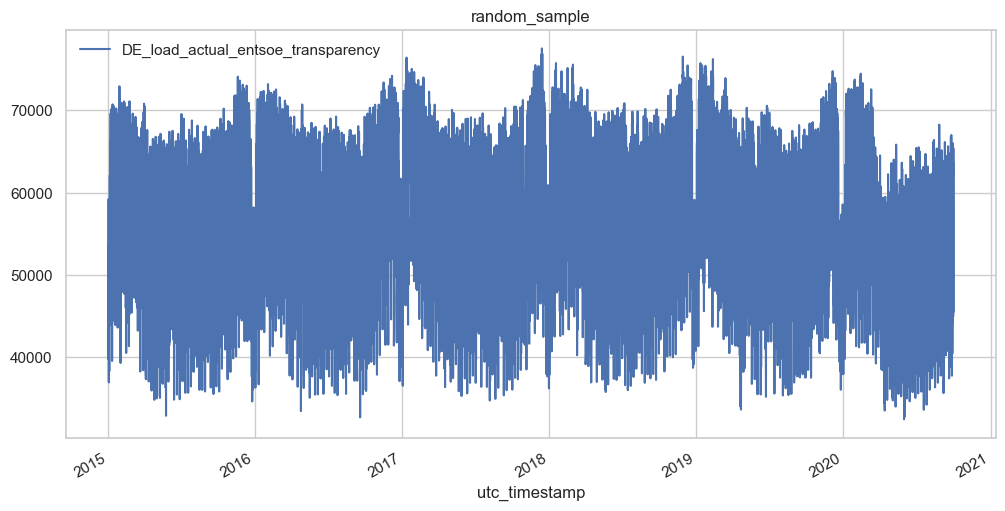

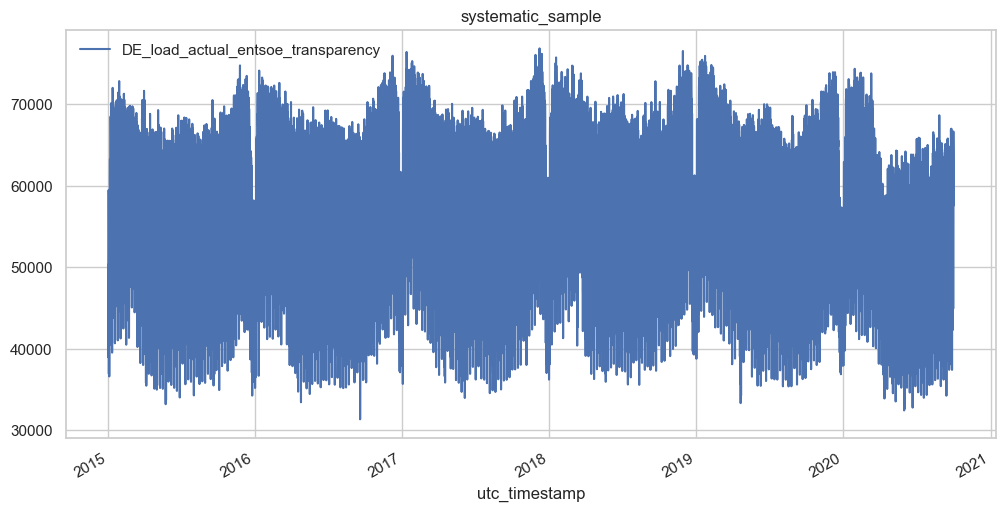

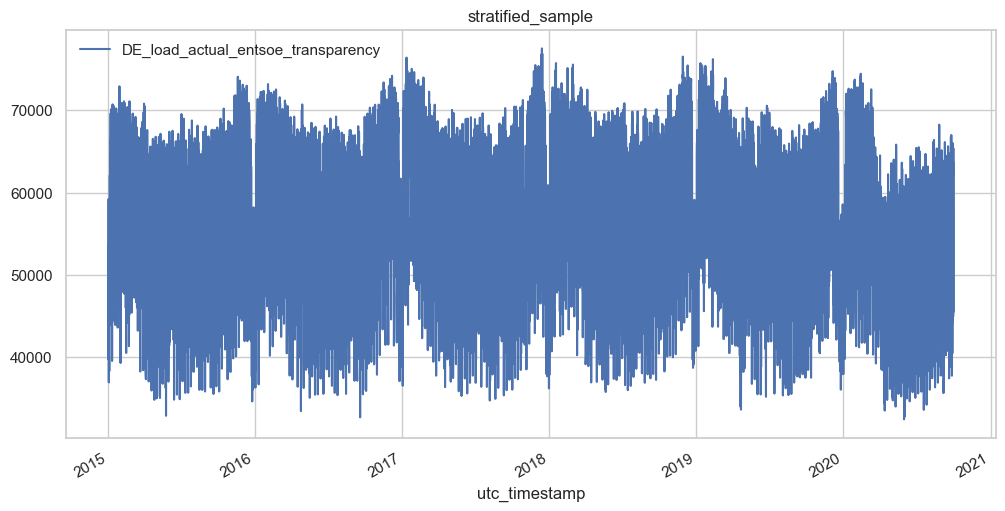

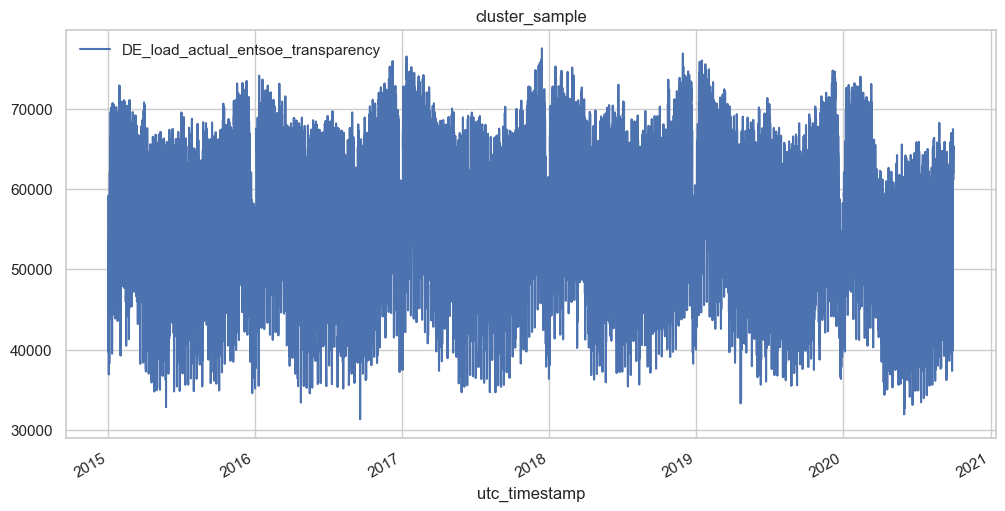

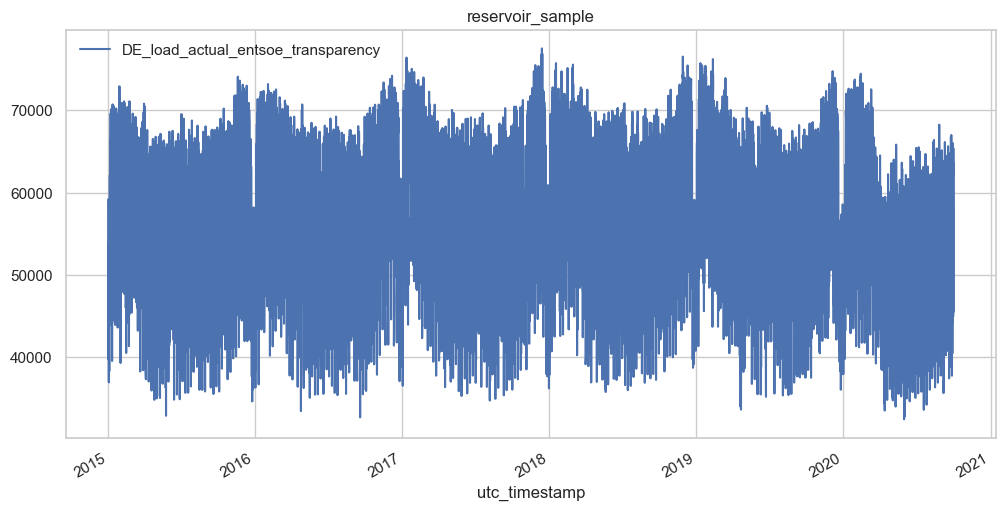

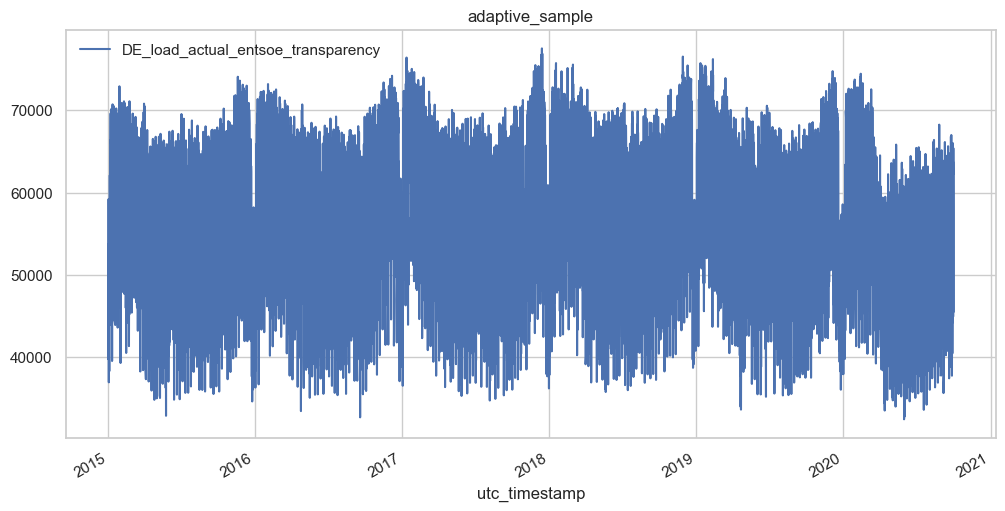

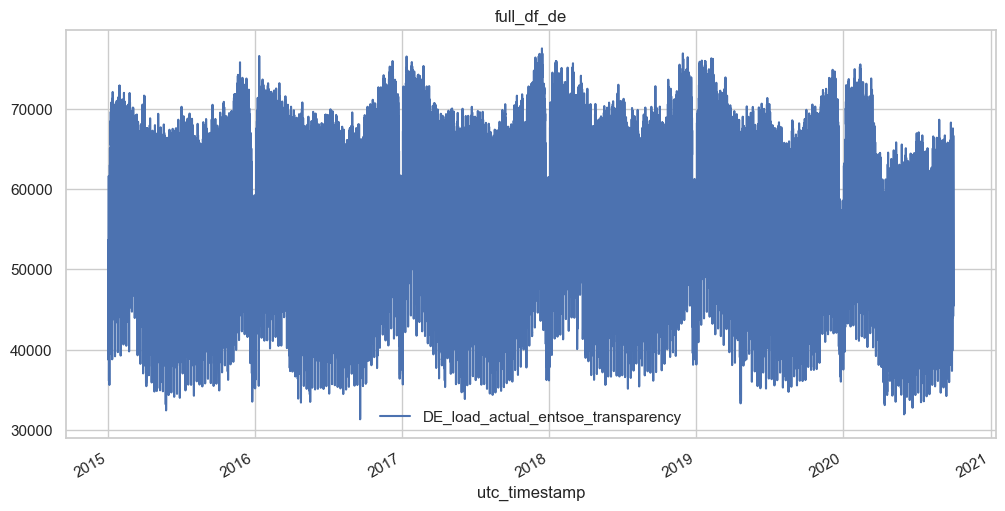

In [23]:
for _df, _title in sample_dataframes:
    plot_line_chart(_df, "utc_timestamp", "DE_load_actual_entsoe_transparency")

plot_line_chart(full_df_de, "utc_timestamp", "DE_load_actual_entsoe_transparency")

##### 5. Sampling Strategies Summary Statistics

In [24]:
# Function to compute basic statistics for a specific column
def compute_column_stats(df, column):
    """Compute basic statistics for a column"""
    stats = df.select(
        F.min(column).alias("min"),
        F.max(column).alias("max"),
        F.mean(column).alias("mean"),
        F.stddev(column).alias("stddev"),
        F.skewness(column).alias("skewness"),
        F.kurtosis(column).alias("kurtosis")
    ).collect()[0]
    
    return {
        "min": stats["min"],
        "max": stats["max"],
        "mean": stats["mean"],
        "stddev": stats["stddev"],
        "skewness": stats["skewness"],
        "kurtosis": stats["kurtosis"]
    }

In [25]:
# Select a few columns for comparison
# selected_columns = [
#     "DE_load_actual_entsoe_transparency"
# ]

selected_columns = [col for col in full_df_de.columns if col != "utc_timestamp"]

In [26]:
# Compute statistics for the full dataset
full_data_stats = {}
for col in selected_columns:
    full_data_stats[col] = compute_column_stats(full_df, col)

In [27]:
full_data_stats

{'DE_load_actual_entsoe_transparency': {'min': 31307.0,
  'max': 77549.0,
  'mean': 55492.4685515873,
  'stddev': 10015.43104161312,
  'skewness': -0.013250973450353792,
  'kurtosis': -1.1013906255380068},
 'DE_load_forecast_entsoe_transparency': {'min': 28824.0,
  'max': 75912.0,
  'mean': 54791.384230585994,
  'stddev': 9496.890313076023,
  'skewness': -0.05112969106652356,
  'kurtosis': -1.0479850380661757},
 'DE_solar_capacity': {'min': 37248.0,
  'max': 50508.0,
  'mean': 42378.01511415525,
  'stddev': 4306.391772930749,
  'skewness': 0.6837379558050154,
  'kurtosis': -0.9836462424408934},
 'DE_solar_generation_actual': {'min': 0.0,
  'max': 32947.0,
  'mean': 4566.042905143448,
  'stddev': 6940.267589678906,
  'skewness': 1.5406988959180095,
  'kurtosis': 1.3767306152007794},
 'DE_solar_profile': {'min': 0.0,
  'max': 0.6873,
  'mean': 0.10190228625045765,
  'stddev': 0.15571754399917132,
  'skewness': 1.5301673026157994,
  'kurtosis': 1.2733401043827675},
 'DE_wind_capacity': {'

In [28]:
# Function to calculate error percentage
def calculate_error(sample_stat, full_stat):
    """Calculate percentage error"""
    if full_stat == 0:
        return float('inf')
    return 100 * abs(sample_stat - full_stat) / abs(full_stat)

In [29]:
# Prepare data structure for comparison
comparison_results = {}

# Define the dataframes to compare
samples = {
    "Random": random_sample,
    "Systematic": systematic_sample,
    "Stratified": stratified_sample,
    "Cluster": cluster_sample,
    "Reservoir": reservoir_sample,
    "Adaptive": adaptive_sample
}

In [30]:
# Calculate and compare statistics
for sample_name, sample_df in samples.items():
    comparison_results[sample_name] = {}
    
    for col in selected_columns:
        sample_stats = compute_column_stats(sample_df, col)
        full_stats = full_data_stats[col]
        
        errors = {}
        for stat_name in ["mean", "stddev"]:
            errors[stat_name] = calculate_error(sample_stats[stat_name], full_stats[stat_name])
        
        comparison_results[sample_name][col] = errors

In [31]:
# Convert to pandas DataFrame for easier visualization
comparison_data = []

for sample_name, cols in comparison_results.items():
    for col_name, errors in cols.items():
        for stat_name, error_val in errors.items():
            comparison_data.append({
                "Sampling Method": sample_name,
                "Column": col_name,
                "Statistic": stat_name,
                "Error Percentage": error_val
            })

# Create the DataFrame from the list of dictionaries
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison results
print("\nError percentages for different sampling methods compared to full dataset:")
pd_comparison = comparison_df.pivot_table(
    index=["Sampling Method", "Column"],
    columns="Statistic",
    values="Error Percentage"
)
print(pd_comparison)


Error percentages for different sampling methods compared to full dataset:
Statistic                                                         mean  \
Sampling Method Column                                                   
Adaptive        DE_50hertz_load_actual_entsoe_transparency    0.142193   
                DE_50hertz_load_forecast_entsoe_transparency  0.208932   
                DE_50hertz_solar_generation_actual            1.569472   
                DE_50hertz_wind_generation_actual             0.267775   
                DE_50hertz_wind_offshore_generation_actual    0.810995   
...                                                                ...   
Systematic      DE_wind_offshore_profile                      0.035464   
                DE_wind_onshore_capacity                      0.001089   
                DE_wind_onshore_generation_actual             0.015658   
                DE_wind_onshore_profile                       0.005389   
                DE_wind_profile     

In [32]:
# Calculate average error by sampling method
avg_errors = comparison_df.groupby("Sampling Method")["Error Percentage"].mean().reset_index()
avg_errors = avg_errors.sort_values("Error Percentage")
print("\nAverage error by sampling method (lower is better):")
print(avg_errors)


Average error by sampling method (lower is better):
  Sampling Method  Error Percentage
5      Systematic          0.049545
1         Cluster          0.389507
0        Adaptive          0.602289
2          Random          0.602289
3       Reservoir          0.602289
4      Stratified          0.632346


##### 6. Visualize comparisons

In [33]:
# 6.1 Convert a Spark DataFrame to Pandas for visualization
def convert_to_pandas(spark_df, columns=None, index_col=None):
    """Convert Spark DataFrame to Pandas DataFrame, with optional column selection"""
    if columns:
        return spark_df.select(columns + [index_col]).toPandas()
    else:
        return spark_df.toPandas()

In [34]:
# 6.2 Visualize distributions for a specific column
def plot_distributions(column, full_df, sample_dfs):
    """
    Plot distribution comparisons between full data and samples
    
    Parameters:
    -----------
    column : str
        Column name to plot
    full_df : pandas.DataFrame
        Full dataset (pandas)
    sample_dfs : dict
        Dictionary of sample dataframes (pandas)
    """
    plt.figure(figsize=(16, 6))
    
    # Plot the full data distribution
    sns.kdeplot(full_df[column], label="Full Dataset", color="black", linewidth=2)
    
    # Plot each sample distribution
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    for i, (name, df) in enumerate(sample_dfs.items()):
        sns.kdeplot(df[column], label=f"{name} Sample", color=colors[i % len(colors)])
    
    plt.title(f"Distribution Comparison for {column}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [35]:
# 6.3 Visualize time series for a specific column
def plot_time_series(column, full_df, sample_dfs, sample_size=1000, index_col="utc_timestamp"):
    """
    Plot time series comparisons between full data and samples
    
    Parameters:
    -----------
    column : str
        Column name to plot
    full_df : pandas.DataFrame
        Full dataset (pandas)
    sample_dfs : dict
        Dictionary of sample dataframes (pandas)
    sample_size : int
        Number of points to plot (to avoid overcrowding)
    """
    plt.figure(figsize=(16, 6))
    
    # Plot a sample of the full data
    full_sample = full_df.sample(sample_size)
    plt.plot(full_sample[index_col], full_sample[column], 'k-', alpha=0.5, label="Full Dataset")
    
    # Plot each sample
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
    for i, (name, df) in enumerate(sample_dfs.items()):
        # Take a subset to avoid overcrowding the plot
        if len(df) > sample_size:
            df_sample = df.sample(sample_size)
        else:
            df_sample = df
        
        plt.scatter(df_sample[index_col], df_sample[column], alpha=0.6, 
                   s=15, label=f"{name} Sample", color=colors[i % len(colors)])
    
    plt.title(f"Time Series Comparison for {column}")
    plt.xlabel(index_col)
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [36]:
# 6.4 Compare error distributions across sampling methods
def plot_error_comparison(comparison_df):
    """Plot error comparison across sampling methods"""
    plt.figure(figsize=(16, 6))
    
    sns.boxplot(x="Sampling Method", y="Error Percentage", data=comparison_df)
    
    plt.title("Error Distribution by Sampling Method")
    plt.xlabel("Sampling Method")
    plt.ylabel("Error Percentage")
    plt.yscale('log')  # Log scale for better visibility of differences
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [37]:
# 6.5 Compare specific statistics across methods
def plot_statistic_comparison(comparison_df, statistic="mean"):
    """Plot comparison of a specific statistic across sampling methods"""
    stat_df = comparison_df[comparison_df["Statistic"] == statistic]
    
    plt.figure(figsize=(16, 6))
    
    sns.barplot(x="Sampling Method", y="Error Percentage", data=stat_df)
    
    plt.title(f"{statistic.capitalize()} Error by Sampling Method")
    plt.xlabel("Sampling Method")
    plt.ylabel(f"{statistic.capitalize()} Error Percentage")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [38]:
# Convert data to pandas for visualization
print("Converting data to pandas for visualization...")
# Use a sample of full data to avoid memory issues
full_data_pd = convert_to_pandas(full_df_de, selected_columns, "utc_timestamp")

sample_dfs = {}
for name, df in samples.items():
    sample_dfs[name] = convert_to_pandas(df, selected_columns, "utc_timestamp")

Converting data to pandas for visualization...


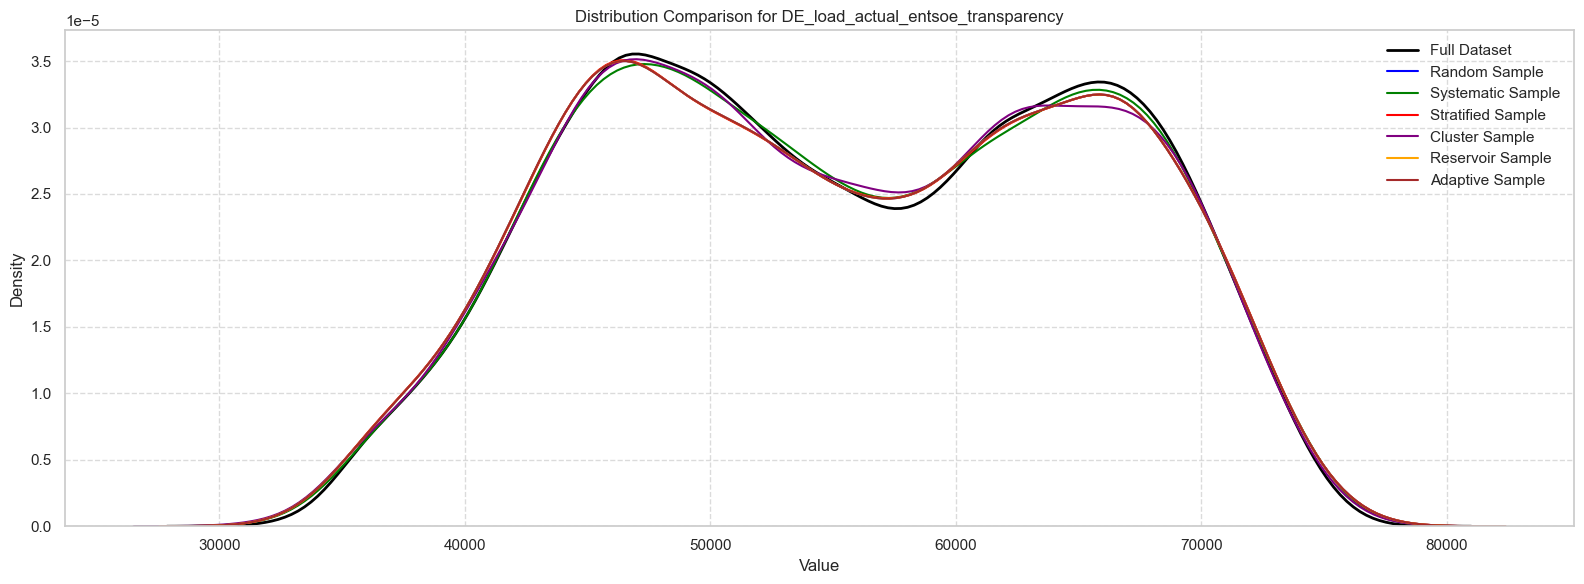

In [39]:
# Plot distributions
for column in selected_columns[:1]:
    plot_distributions(column, full_data_pd, sample_dfs)

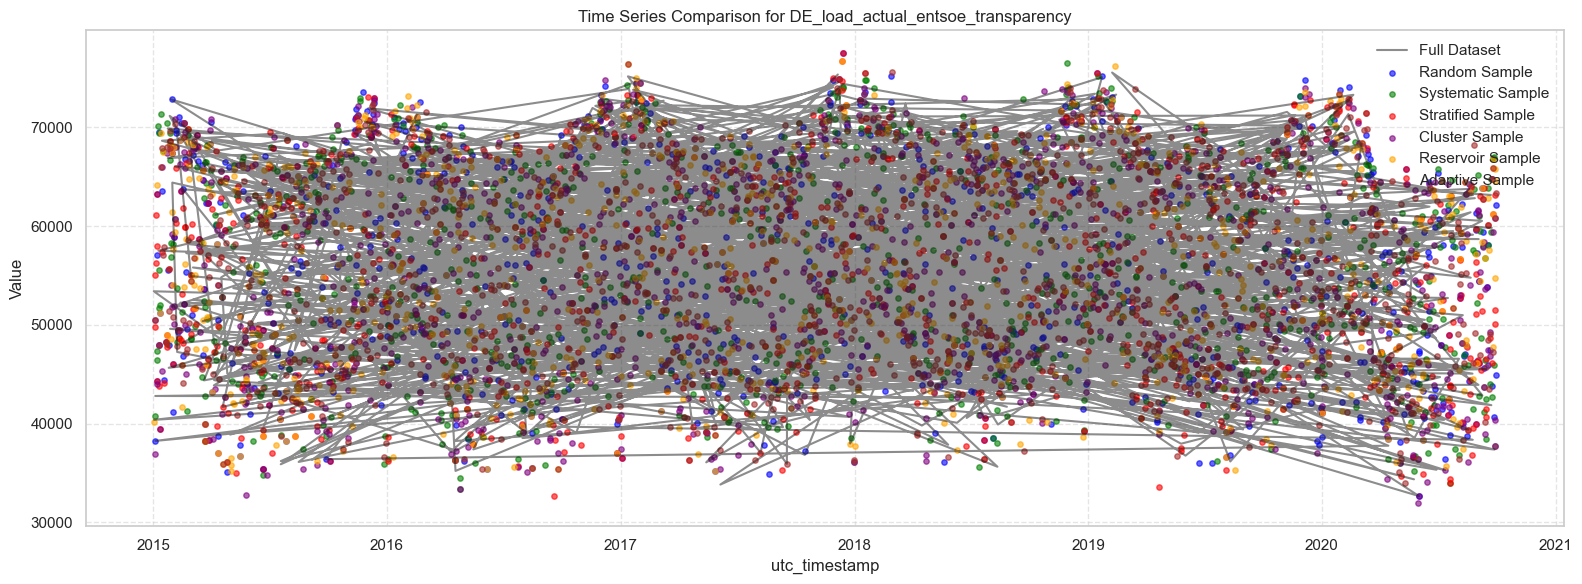

In [40]:
# Plot time series
for column in selected_columns[:1]:
    plot_time_series(column, full_data_pd, sample_dfs)

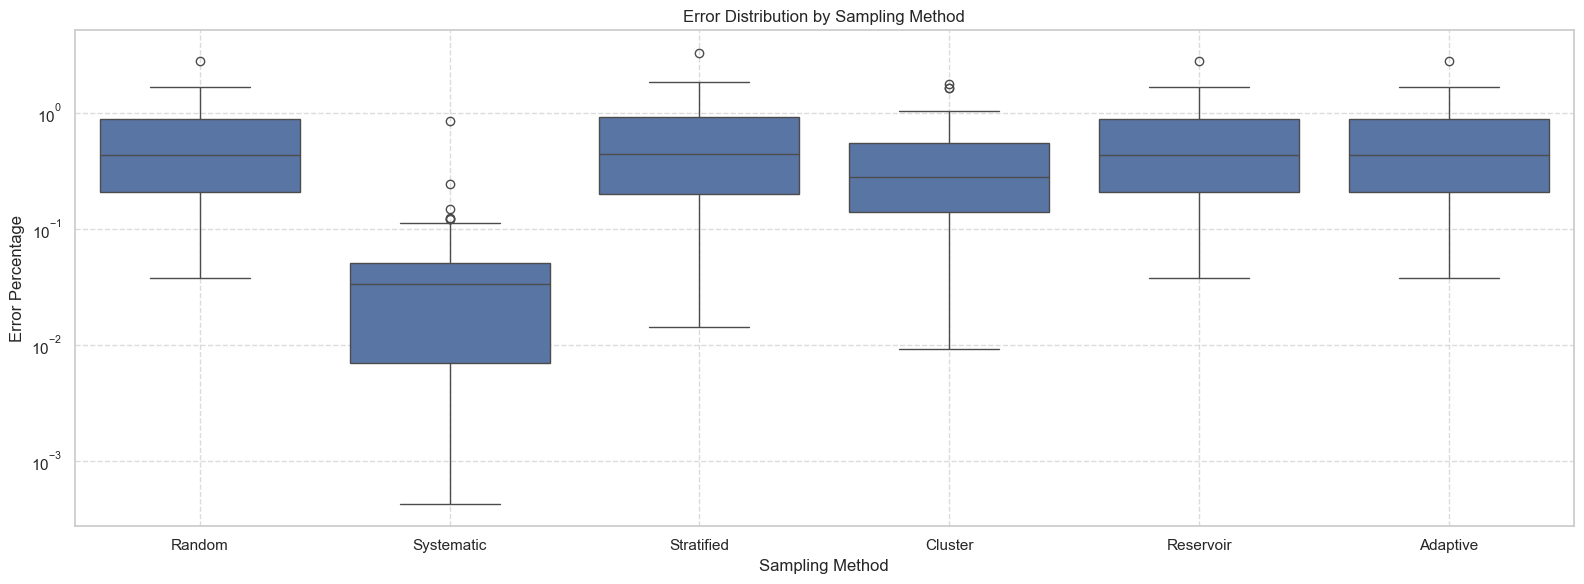

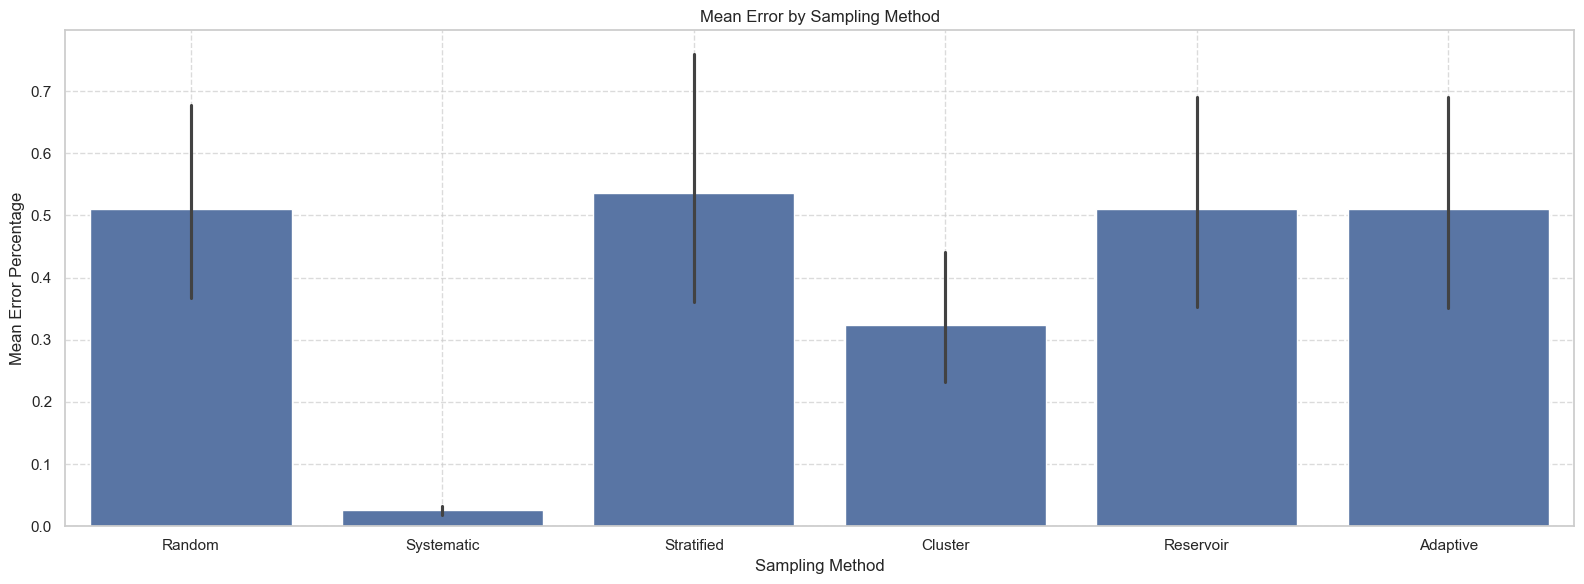

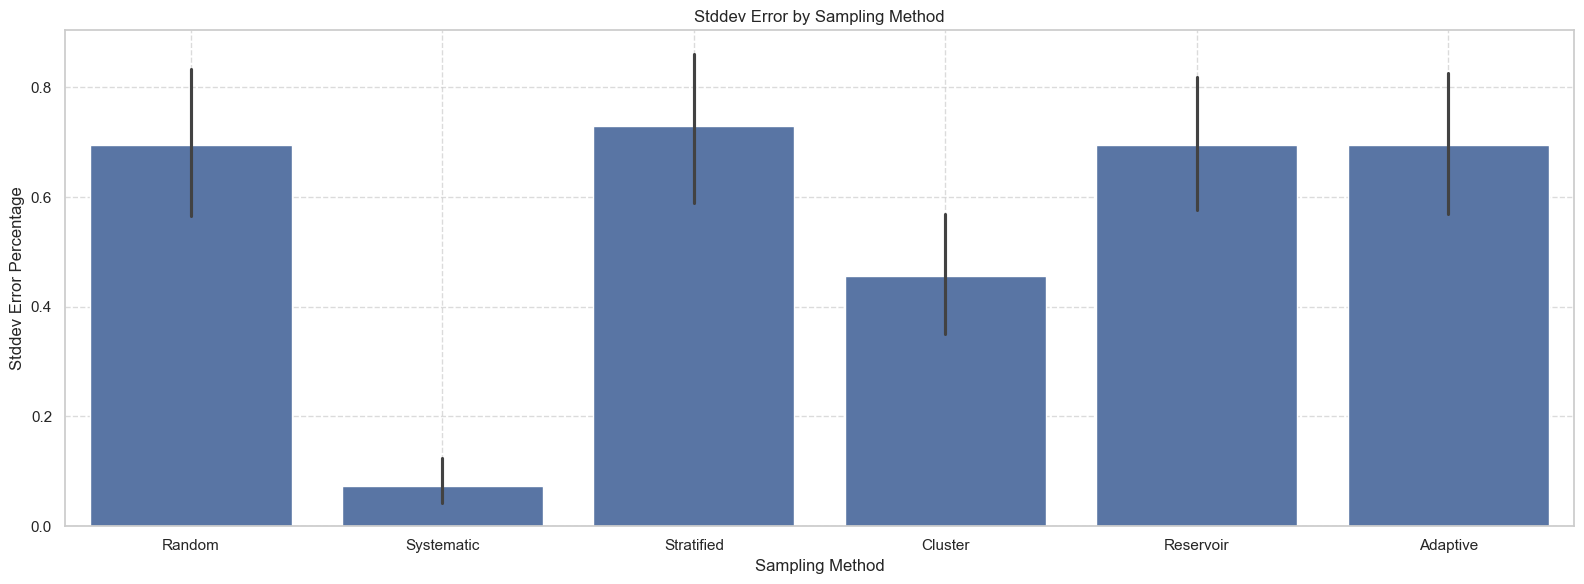

In [41]:
# Plot error comparisons
plot_error_comparison(comparison_df)
plot_statistic_comparison(comparison_df, "mean")
plot_statistic_comparison(comparison_df, "stddev")

##### 7. Recomended Sampling Strategy

In [42]:
# Determine the best sampling method based on lowest average error
best_method = avg_errors.iloc[0]["Sampling Method"]
print(f"\nRecommended sampling method: {best_method}")


Recommended sampling method: Systematic


In [43]:
# Provide recommendations based on error analysis
recommended_sample_size = sample_size

# If the best method is adaptive sampling, use its adjusted sample size
if best_method == "Adaptive":
    recommended_sample_size = adaptive_sample.count()

print(f"Recommended sample size: {recommended_sample_size}")

Recommended sample size: 9604


In [44]:
# Add recommendations based on performance analysis
print("\nRecommendations based on performance analysis:")
print("1. Use the selected sampling method for your EDA and statistical analysis")
print(f"2. The sample size of {recommended_sample_size} should provide estimates with a margin of error "
      f"of approximately {MARGIN_OF_ERROR*100}% at a {CONFIDENCE_LEVEL*100}% confidence level")
print("3. For time-critical visualizations and EDA tasks, this sample provides a good balance "
      "between accuracy and computational efficiency")


Recommendations based on performance analysis:
1. Use the selected sampling method for your EDA and statistical analysis
2. The sample size of 9604 should provide estimates with a margin of error of approximately 1.0% at a 95.0% confidence level
3. For time-critical visualizations and EDA tasks, this sample provides a good balance between accuracy and computational efficiency


In [45]:
# Additional recommendations based on data characteristics
print("\nAdditional recommendations:")
print("- For time series pattern detection, ensure your sampling preserves the temporal patterns")
print("- For anomaly detection, systematic or stratified sampling are recommended")
print("- For correlation analysis between sensors, ensure sample represents the full feature space")
print("- Consider using different sampling strategies for different analysis tasks")


Additional recommendations:
- For time series pattern detection, ensure your sampling preserves the temporal patterns
- For anomaly detection, systematic or stratified sampling are recommended
- For correlation analysis between sensors, ensure sample represents the full feature space
- Consider using different sampling strategies for different analysis tasks


##### 8. Implementation

In [47]:
print("\nImplementing the recommended sampling strategy for production...")

# Function to apply the best sampling method
def apply_best_sampling(data, sample_size, best_method):
    """Apply the best sampling method determined by analysis"""
    
    if best_method == "Random":
        return random_sampling(data, sample_size)
    elif best_method == "Systematic":
        return systematic_sampling(data, sample_size)
    elif best_method == "Stratified":
        return stratified_time_sampling(data, sample_size)
    elif best_method == "Cluster":
        return cluster_sampling(data, sample_size)
    elif best_method == "Reservoir":
        return reservoir_sampling_simulation(data, sample_size)
    elif best_method == "Adaptive":
        return adaptive_sampling(data, sample_size, sample_size*5)
    else:
        # Default to random sampling
        return random_sampling(data, sample_size)

# Sample implementation for production
def production_sampling_and_analysis(data, best_method, confidence_level=0.95, margin_of_error=0.01):
    """
    Production function for sampling and analysis
    
    Parameters:
    -----------
    data : pyspark.sql.DataFrame
        Input time series data
    confidence_level : float
        Desired confidence level (default: 0.95)
    margin_of_error : float
        Desired margin of error (default: 0.03)
    
    Returns:
    --------
    pyspark.sql.DataFrame
        Sampled data
    """
    # Calculate required sample size
    sample_size = calculate_sample_size(confidence_level, margin_of_error)
    
    # Apply the best sampling method
    sampled_data = apply_best_sampling(data, sample_size, best_method)
    
    print(f"Applied {best_method} sampling with size {sampled_data.count()}")
    print(f"Expected error: ±{margin_of_error*100}% at {confidence_level*100}% confidence level")
    
    return sampled_data

# Example usage
final_sample = production_sampling_and_analysis(full_df_de, best_method)
print(f"Final sample size: {final_sample.count()}")


Implementing the recommended sampling strategy for production...
Total records: 50401, Sample size: 9604, Step size: 5
Applied Systematic sampling with size 10080
Expected error: ±1.0% at 95.0% confidence level
Final sample size: 10080


### Summary Statistics

In [48]:
full_df_de.describe().show()

+-------+----------------------------------+------------------------------------+-----------------+--------------------------+-------------------+-----------------+-------------------------+-------------------+-------------------------+----------------------------------+------------------------+------------------------+---------------------------------+-----------------------+------------------------------------------+--------------------------------------------+----------------------------------+---------------------------------+------------------------------------------+-----------------------------------------+-------------------------------------+---------------------------------------+---------------------+-----------------------------+----------------------------+-------------------------------------+------------------------------------+------------------------------------------+--------------------------------------------+----------------------------------+----------------------

### Missing Values

In [49]:
from pyspark.sql.functions import col, sum as spark_sum

def analyze_missing_values(df, output_dir=None):
    """
    Analyze missing values in the DataFrame efficiently.
    
    Parameters:
    -----------
    df : PySpark DataFrame
        DataFrame to analyze
    output_dir : str, optional
        Directory to save the results. If None, results are not saved.
        
    Returns:
    --------
    pd.DataFrame
        Missing values statistics
    """
    # Calculate total count of rows
    total_count = df.count()
    
    # Compute missing counts for all columns in one pass
    missing_counts = df.select(
        [spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
    ).collect()[0]
    
    # Create a list to hold missing value information
    missing_list = []
    
    for column_name in df.columns:
        missing_count = missing_counts[column_name]
        missing_percentage = (missing_count / total_count) * 100
        
        missing_list.append({
            "Column": column_name,
            "Missing Count": missing_count,
            "Missing Percentage": missing_percentage
        })
    
    # Convert to pandas DataFrame for easier visualization
    missing_df = pd.DataFrame(missing_list)
    missing_df = missing_df.sort_values("Missing Percentage", ascending=False)
    
    # Save missing values information if output_dir is provided
    if output_dir:
        missing_df.to_csv(f"{output_dir}/missing_values.csv", index=False)
    
    return missing_df

In [60]:
analyze_missing_values(full_df_de)

,Column,Missing Count,Missing Percentage
22,DE_LU_load_forecast_entsoe_transparency,33745,66.953037
21,DE_LU_load_actual_entsoe_transparency,32877,65.230849
24,DE_LU_solar_generation_actual,32862,65.201087
23,DE_LU_price_day_ahead,32861,65.199103
27,DE_LU_wind_onshore_generation_actual,32855,65.187199
25,DE_LU_wind_generation_actual,32855,65.187199
26,DE_LU_wind_offshore_generation_actual,32855,65.187199
5,DE_solar_profile,6705,13.303307
8,DE_wind_profile,6676,13.245769
11,DE_wind_offshore_profile,6676,13.245769


C:\Users\SteliosLiaros\AppData\Local\Temp\ipykernel_13960\1350510306.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Missing Percentage', y='Column', data=filtered_df, palette='viridis')


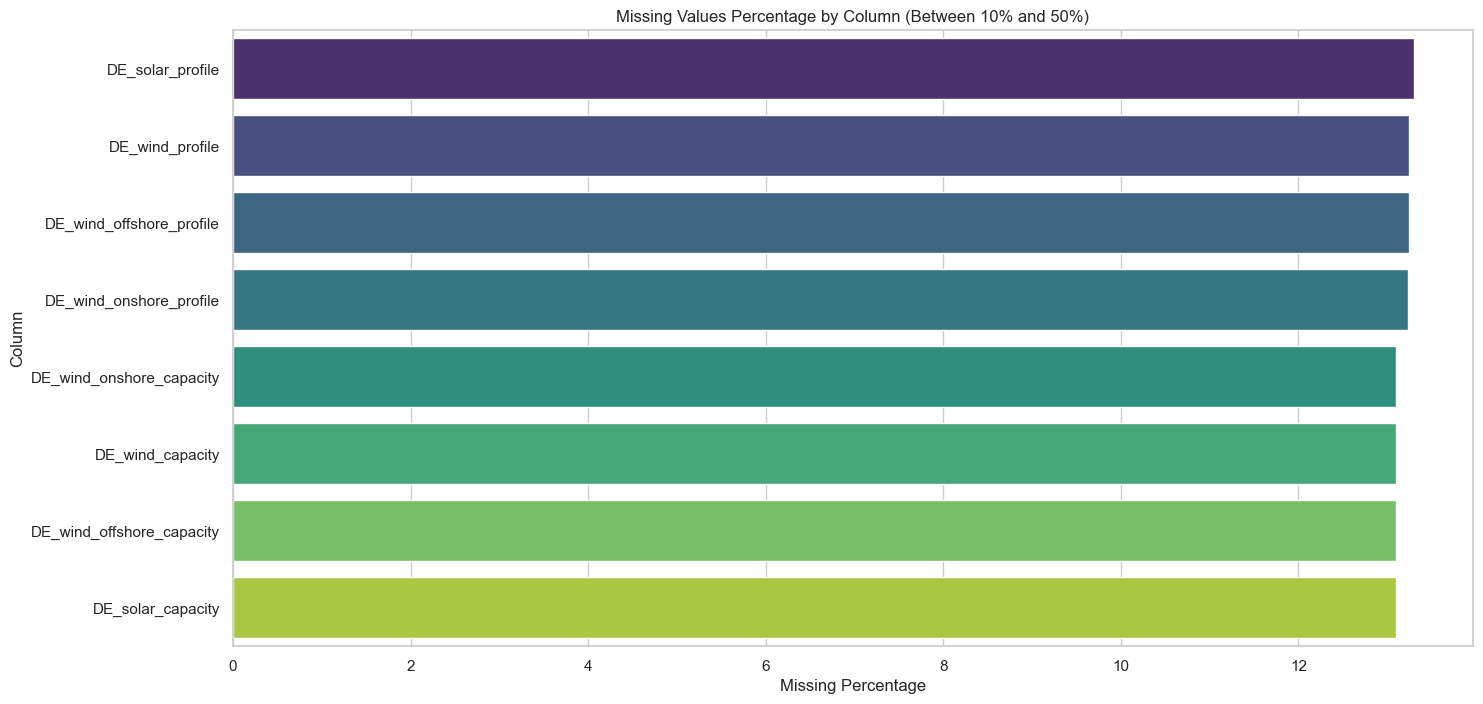

In [61]:
import seaborn as sns

import matplotlib.pyplot as plt

def plot_missing_values_between(missing_df, min_percentage, max_percentage):
    """
    Plot a bar chart of missing values percentages for columns with missing percentage between min_percentage and max_percentage.
    
    Parameters:
    -----------
    missing_df : pd.DataFrame
        DataFrame containing missing values statistics with columns 'Column', 'Missing Count', and 'Missing Percentage'
    min_percentage : float
        Minimum missing percentage to filter columns
    max_percentage : float
        Maximum missing percentage to filter columns
    """
    # Filter the DataFrame based on the given percentage range
    filtered_df = missing_df[(missing_df['Missing Percentage'] >= min_percentage) & (missing_df['Missing Percentage'] <= max_percentage)]
    
    # Plot using seaborn barplot
    plt.figure(figsize=(16, 8))
    sns.barplot(x='Missing Percentage', y='Column', data=filtered_df, palette='viridis')
    plt.title(f'Missing Values Percentage by Column (Between {min_percentage}% and {max_percentage}%)')
    plt.xlabel('Missing Percentage')
    plt.ylabel('Column')
    plt.show()

# Example usage
missing_df = analyze_missing_values(full_df_de)
plot_missing_values_between(missing_df, 10, 50)

In [64]:
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt

# Function 1: Create a boolean mask for missing values
def create_missing_mask(df):
    """
    Create a boolean mask indicating missing values in the DataFrame.
    
    Parameters:
    -----------
    df : PySpark DataFrame
        The input DataFrame.
        
    Returns:
    --------
    PySpark DataFrame
        A DataFrame with the same structure as `df`, where each value is `True` (missing) or `False` (not missing).
    """
    return df.select([col(c).isNull().alias(c) for c in df.columns])

# Function 2: Collect the mask and convert it to a NumPy array
def mask_to_numpy_array(missing_mask):
    """
    Collect the boolean mask and convert it to a NumPy array.
    
    Parameters:
    -----------
    missing_mask : PySpark DataFrame
        The boolean mask DataFrame.
        
    Returns:
    --------
    np.ndarray
        A NumPy array representing the boolean mask.
    """
    # Collect the mask as a list of rows
    missing_data = missing_mask.collect()
    
    # Convert the collected data to a NumPy array
    return np.array([list(row) for row in missing_data], dtype=bool)

# Function 3: Visualize the missing values using matplotlib
def visualize_missing_values(missing_array):
    """
    Visualize the missing values using a heatmap.
    
    Parameters:
    -----------
    missing_array : np.ndarray
        A NumPy array representing the boolean mask.
    """
    plt.figure(figsize=(16, 6))
    plt.imshow(missing_array, aspect="auto", interpolation="nearest", cmap="gray")
    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")
    plt.title("Missing Values Visualization")
    plt.colorbar(label="Missing (True) / Not Missing (False)")
    plt.show()

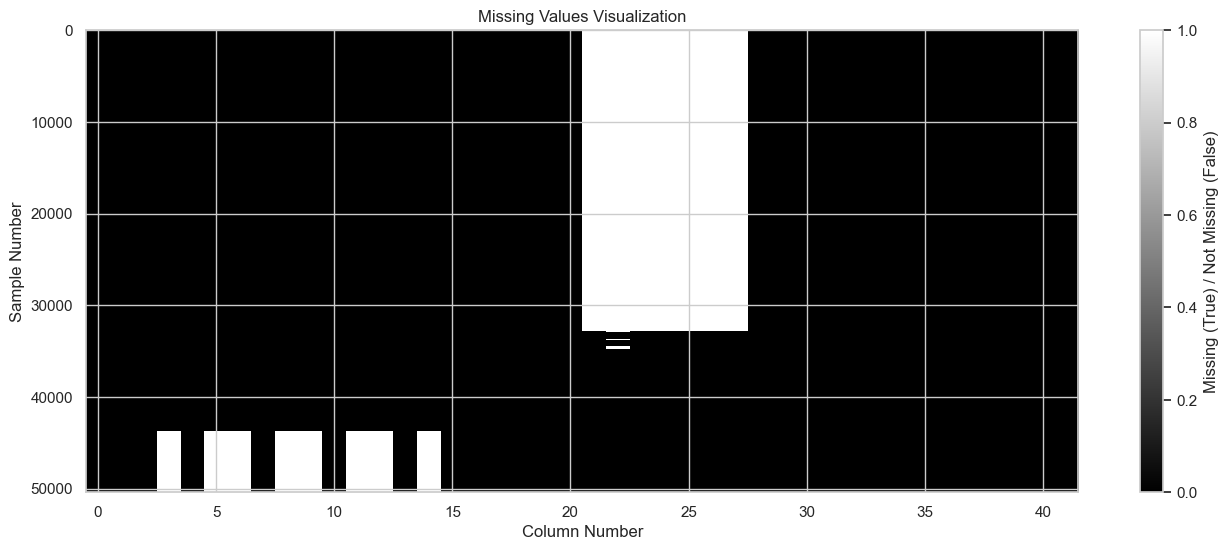

In [68]:
missing_mask = create_missing_mask(full_df_de)
missing_array = mask_to_numpy_array(missing_mask)
visualize_missing_values(missing_array)

### Duplicated Values

In [66]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, count

def detect_duplicates_optimized(df, columns, output_dir=None):
    """
    Detect duplicates in a PySpark DataFrame efficiently and provide additional insights.
    
    Parameters:
    -----------
    df : PySpark DataFrame
        DataFrame to analyze.
    columns : list
        List of column names to check for duplicates.
    output_dir : str, optional
        Directory to save the results. If None, results are not saved.
        
    Returns:
    --------
    tuple
        - PySpark DataFrame: Full duplicate rows.
        - PySpark DataFrame: Summary of duplicate counts per group.
    """
    
    # If no columns are specified, use all columns for partitioning
    if columns is None:
        columns = df.columns
    
    # Define a window partitioned by the specified or all columns
    window = Window.partitionBy(columns)
    
    # Add a count column to identify duplicates
    df_with_count = df.withColumn("duplicate_count", count("*").over(window))
    
    # Filter rows where duplicate_count > 1 (duplicates)
    duplicates_full = df_with_count.filter(col("duplicate_count") > 1).drop("duplicate_count")
    
    # Create a summary of duplicate counts per group
    duplicates_summary = df_with_count.groupBy(columns).agg(
        count("*").alias("duplicate_count")
    ).filter("duplicate_count > 1")
    
    # Save results if output_dir is provided
    if output_dir:
        duplicates_full.write.csv(f"{output_dir}/duplicates_full", header=True, mode="overwrite")
        duplicates_summary.write.csv(f"{output_dir}/duplicates_summary", header=True, mode="overwrite")
    
    return duplicates_full, duplicates_summary

In [69]:
detect_duplicates_optimized(full_df_de, full_df_de.columns)

(DataFrame[utc_timestamp: timestamp, DE_load_actual_entsoe_transparency: double, DE_load_forecast_entsoe_transparency: double, DE_solar_capacity: double, DE_solar_generation_actual: double, DE_solar_profile: double, DE_wind_capacity: double, DE_wind_generation_actual: double, DE_wind_profile: double, DE_wind_offshore_capacity: double, DE_wind_offshore_generation_actual: double, DE_wind_offshore_profile: double, DE_wind_onshore_capacity: double, DE_wind_onshore_generation_actual: double, DE_wind_onshore_profile: double, DE_50hertz_load_actual_entsoe_transparency: double, DE_50hertz_load_forecast_entsoe_transparency: double, DE_50hertz_solar_generation_actual: double, DE_50hertz_wind_generation_actual: double, DE_50hertz_wind_offshore_generation_actual: double, DE_50hertz_wind_onshore_generation_actual: double, DE_LU_load_actual_entsoe_transparency: double, DE_LU_load_forecast_entsoe_transparency: double, DE_LU_price_day_ahead: double, DE_LU_solar_generation_actual: double, DE_LU_wind_ge